#### Import packages & Enable CUDA

In [8]:
import torch
from torch import nn, optim, autograd
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


#### Colored MNIST dataset

In [2]:
class MNISTDataset(datasets.VisionDataset):
    def __init__(self, root: str) -> None:
        super(MNISTDataset, self).__init__(root)
        self.data_label = torch.load(root)
        self.transform = transforms.Compose([
            transforms.Resize(14),
            transforms.ToTensor()
        ])
        self.images = []
        self.targets = []
        for image, target in self.data_label:
            self.images.append(np.array(image))
            self.targets.append(target)
        self.images = torch.tensor(np.array(self.images))
        self.targets = torch.tensor(np.array(self.targets))

    def __len__(self) -> int:
        return 20000

    def __getitem__(self, index):
        image, target = self.data_label[index]
        return self.transform(image), target

#### Environment Definition & Instantiation

In [3]:
class Environment:
    def __init__(self, dataset: MNISTDataset) -> None:
        self.size = len(dataset)
        images = []
        targets = []
        for image, target in dataset:
            images.append(image.unsqueeze_(0))
            targets.append(target)
        self.images = torch.cat(images, dim=0).to(device)
        self.targets = torch.Tensor(targets).unsqueeze_(1).to(device)
        self.loss = None
        self.accuracy = None
        self.penalty = None

    def update(self, inputs):
        self.loss = F.binary_cross_entropy_with_logits(self.targets, inputs)
        predictions = (inputs > 0.).float()
        self.accuracy = ((self.targets - predictions).abs() < 0.01).float().mean()
        scale = torch.tensor(1., requires_grad=True).to(device)
        loss = F.binary_cross_entropy_with_logits(scale * inputs, self.targets)
        gradient = autograd.grad(loss, [scale], create_graph=True)[0]
        self.penalty = torch.sum(gradient ** 2)


train1 = Environment(MNISTDataset('./ColoredMNIST/train1.pt'))
print("Dataset train1 loaded, size = {}".format(train1.size))

train2 = Environment(MNISTDataset('./ColoredMNIST/train2.pt'))
print("Dataset train2 loaded, size = {}".format(train1.size))

test = Environment(MNISTDataset('./ColoredMNIST/test.pt'))
print("Dataset test loaded, size = {}".format(train1.size))

Dataset train1 loaded, size = 20000
Dataset train2 loaded, size = 20000
Dataset test loaded, size = 20000


#### MLP model construction

In [4]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        layer1 = nn.Linear(3 * 14 * 14, 256)
        layer2 = nn.Linear(256, 256)
        layer3 = nn.Linear(256, 1)
        for layer in [layer1, layer2, layer3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        self.model = nn.Sequential(
            nn.Flatten(),
            layer1,
            nn.ReLU(True),
            layer2,
            nn.ReLU(True),
            layer3
        )

    def forward(self, inputs):
        outputs = self.model(inputs)
        return outputs

#### Training & Validation

In [29]:
model = MNISTModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

states = []

for epoch in range(501):
    for group in [train1, train2, test]:
        results = model(group.images)
        group.update(results)

    train_loss = (train1.loss + train2.loss) / 2.
    train_accuracy = (train1.accuracy + train2.accuracy) / 2.
    train_penalty = (train1.penalty + train2.penalty) / 2.
    test_accuracy = test.accuracy
    states.append([train_accuracy.item(), test_accuracy.item()])

    parameter_norm = torch.tensor(0.).to(device)
    for p in model.parameters():
        parameter_norm += p.norm().pow(2)

    norm_weight = 0.001
    penalty_weight = 10000.0 if epoch >= 100 else 1.0

    total_loss = train_loss.clone()
    total_loss += norm_weight * parameter_norm
    total_loss += penalty_weight * train_penalty

    if penalty_weight > 1.0:
        total_loss /= penalty_weight

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: {}, Train Accuracy: {}, Test Accuracy: {}".format(epoch, train_accuracy, test_accuracy))

Epoch: 0, Train Accuracy: 0.6215499639511108, Test Accuracy: 0.3190999925136566
Epoch: 100, Train Accuracy: 0.8383749723434448, Test Accuracy: 0.22974999248981476
Epoch: 200, Train Accuracy: 0.71527498960495, Test Accuracy: 0.45409998297691345
Epoch: 300, Train Accuracy: 0.6909749507904053, Test Accuracy: 0.6448000073432922
Epoch: 400, Train Accuracy: 0.667199969291687, Test Accuracy: 0.685699999332428
Epoch: 500, Train Accuracy: 0.6516249775886536, Test Accuracy: 0.6915000081062317


#### Learning curve

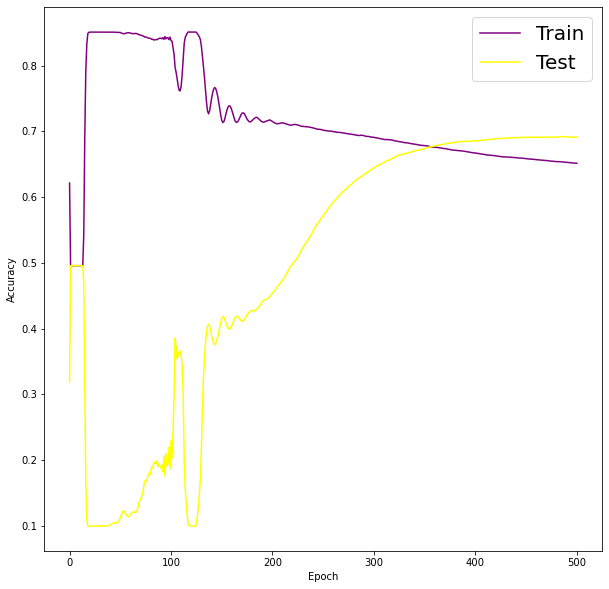

In [31]:
steps = np.linspace(0, 500, 501)
states = np.array(states)
plt.figure(figsize=(10, 10))
plt.plot(steps, states[:, 0], c='purple', label='Train')
plt.plot(steps, states[:, 1], c='yellow', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(prop={'size': 20})
plt.show()